## Predicción del precio medio del aguacate usando técnicas de modelado de series temporales.

### Tabla de contenidos:
- [Importacion de librerias y otro codigo util](#importacion-de-librerias-y-otro-codigo-util)
- [Analisis exploratorio de los datos](#analisis-exploratorio-de-los-datos)
    - [Lectura y carga del dataset](#lectura-y-carga-del-dataset)
    - [Visualizacion de las variables](#visualizacion-de-las-variables)
    - [Visualizacion de la serie temporal](#visualizacion-de-la-serie-temporal)
- [Aplicamos **ARIMA**](#aplicamos-arima)
    - [¿Tiene tendencia o es estacionaria? --> Parametro ``d``](#tiene-tendencia-o-es-estacionaria----parametro-d)
    - [Parametros ``p`` y ``q`` --> **auto_arima**](#parametros-p-y-q----auto_arima)
    - [Modelizacion](#modelizacion)
    - [Visualizacion del modelo entrenado](#visualizacion-del-modelo-entrenado)
    - [Visualizacion de las predicciones](#visualizacion-de-las-predicciones)
    - [Predicciones](#predicciones)
- [Aplicamos **Prophet**](#aplicamos-prophet)
    - [Filtramos dataframe](#filtramos-dataframe)
    - [Renombramos columnas y cambiamos formato de fechas](#renombramos-columnas-y-cambiamos-formato-de-fechas)
    - [Entrenamos modelo Prophet](#entrenamos-modelo-prophet)
    - [Realizamos predicciones](#realizamos-predicciones)
    - [Visualizamos las predicciones](#visualizamos-las-predicciones)
    - [Prediccion para una region concreta: Las Vegas](#prediccion-para-una-region-concreta-las-vegas)

DESCRIPCIÓN DE LAS VARIABLES:

- ``Date`` :The date of the observation

- ``AveragePrice`` : the average price of a single avocado

- ``Total Volume`` : Total number of avocados sold

- ``4046`` : Total number of avocados with PLU 4046 sold

- ``4225`` : Total number of avocados with PLU 4225 sold

- ``4770`` : Total number of avocados with PLU 4770 sold

- ``Total Bags`` : Total number of bags

- ``Small Bags`` : Total number of small bags

- ``Large Bags`` : Total number of large bags

- ``XLarge Bags`` : Extra Large Bags

- ``type`` : conventional or organic

- ``year`` : year of the date

- ``region`` : the city or region of the observation

### Importacion de librerias y otro codigo util

In [40]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ARIMA
from statsmodels.tsa.stattools import adfuller 
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
# Prophet
from prophet import Prophet

In [2]:
green_palette = sns.color_palette('Greens')

### Analisis exploratorio de los datos

#### Lectura y carga del dataset

In [4]:
avocado = pd.read_csv(r'./data/avocado.csv')
avocado.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
avocado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [6]:
avocado.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
avocado['type'].unique()

array(['conventional', 'organic'], dtype=object)

In [8]:
avocado['type'].value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

In [9]:
# visualizacion de los valores nulos
avocado.isnull().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [10]:
# visualizacion de los valores duplicados
avocado.duplicated().sum()

0

#### Visualizacion de las variables

In [11]:
avocado.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

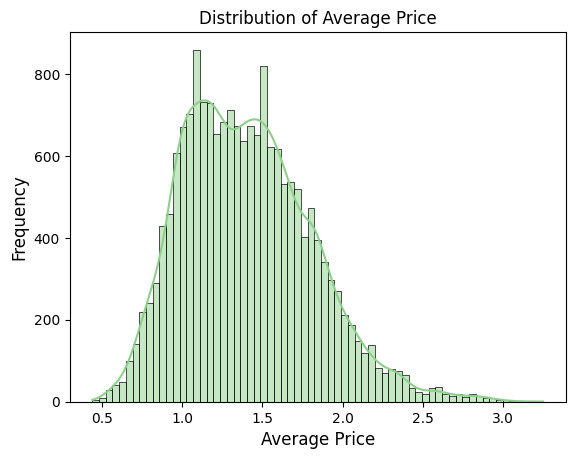

In [12]:
#Visualizo la distribución de la variable 'AveragePrice'

sns.histplot(avocado['AveragePrice'], kde=True, color=green_palette[2])
plt.title('Distribution of Average Price', fontsize=12)
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12);

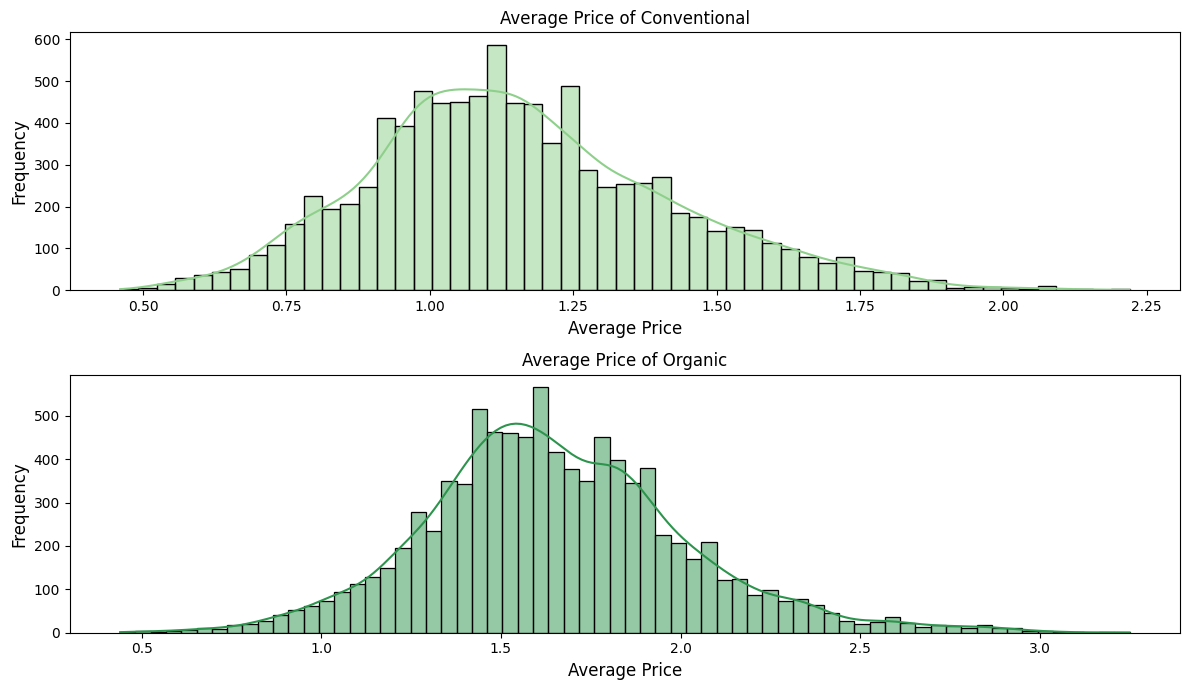

In [13]:
#Visualizo la distribución de la variable 'AveragePrice' por cada tipo de aguacate

avocado_conv = avocado[avocado["type"] == "conventional"]
avocado_org = avocado[avocado["type"] == "organic"]

# Crear figura y ejes para los subplots
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))
# Histograma para 'conventional'
sns.histplot(avocado_conv['AveragePrice'], kde=True, color=green_palette[2], ax=ax1)
ax1.set_title('Average Price of Conventional', fontsize=12)
ax1.set_xlabel('Average Price', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
# Histograma para 'organic'
sns.histplot(avocado_org['AveragePrice'], kde=True, color=green_palette[4], ax=ax2)
ax2.set_title('Average Price of Organic', fontsize=12)
ax2.set_xlabel('Average Price', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
# Ajustar el espacio entre subplots
plt.tight_layout()
# Mostrar la figura
plt.show()

WARNING - (py.warnings._showwarnmsg) - C:\Users\kina5\AppData\Local\Temp\ipykernel_19256\1709994373.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(x="type", y="AveragePrice",data=avocado, hue='type', palette=green_palette)



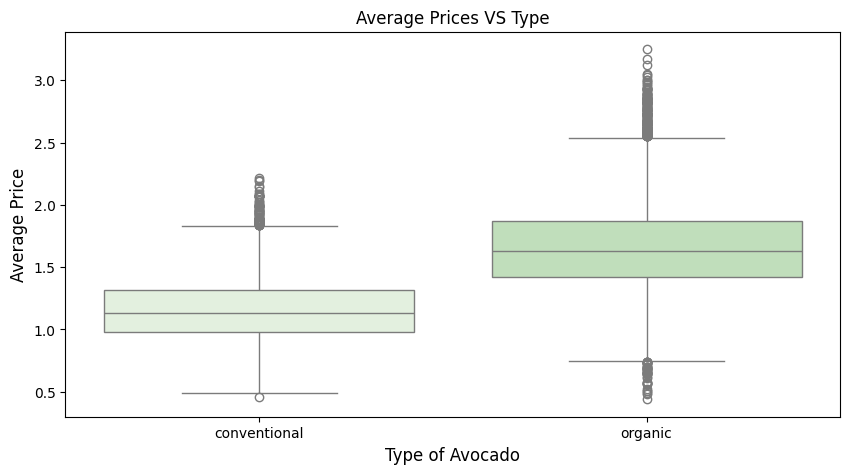

In [14]:
# comparacion de los precios por tipo de aguacate
f,ax = plt.subplots(figsize = (10,5))
sns.boxplot(x="type", y="AveragePrice",data=avocado, hue='type', palette=green_palette)
plt.title("Average Prices VS Type",fontsize = 12)
plt.xlabel('Type of Avocado',fontsize = 12)
plt.ylabel('Average Price',fontsize = 12);

#### Visualizacion de la serie temporal

In [17]:
# Nos aseguramos de que la columna 'Date' esté en formato datetime
avocado['Date'] = pd.to_datetime(avocado['Date'])
avocado_conv['Date'] = pd.to_datetime(avocado['Date'])
avocado_org['Date'] = pd.to_datetime(avocado['Date'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\kina5\AppData\Local\Temp\ipykernel_19256\3565285032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avocado_conv['Date'] = pd.to_datetime(avocado['Date'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\kina5\AppData\Local\Temp\ipykernel_19256\3565285032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avocado_org['Date'] = pd.to_datetime(avocado['Date'])



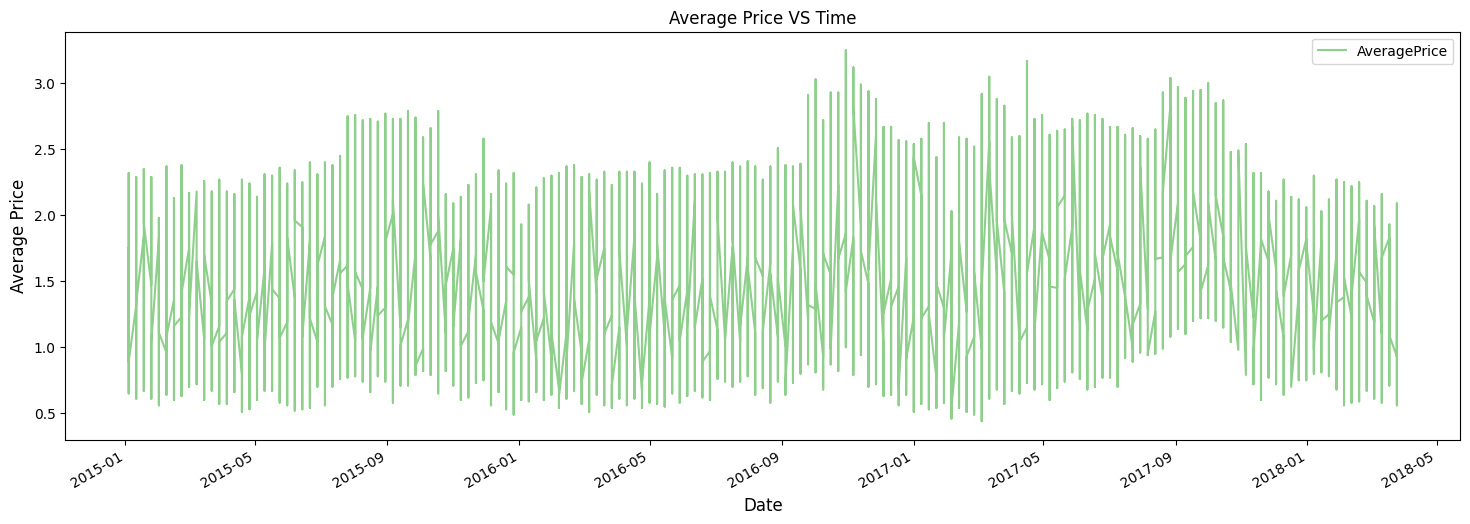

In [25]:
fig, ax = plt.subplots(1,1, figsize=(18,6))
avocado.set_index('Date').plot(y='AveragePrice', ax=ax, color=green_palette[2])
plt.title('Average Price VS Time', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price', fontsize=12);

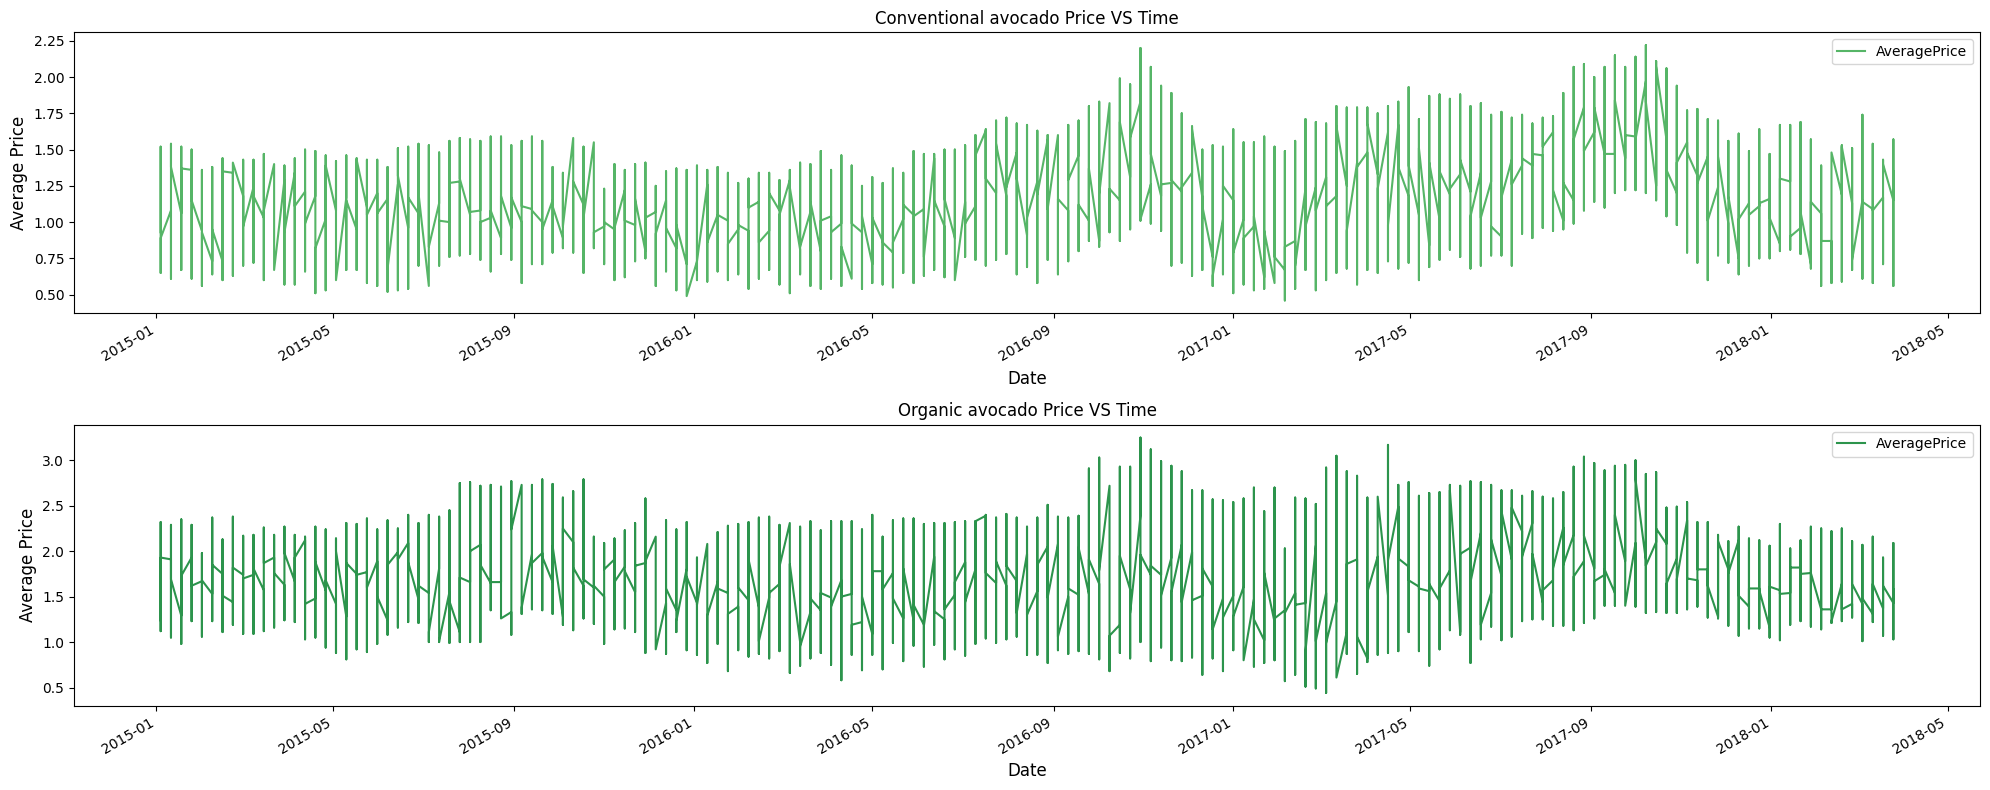

In [21]:
# visualizacion de la serie temporal por cada tipo de aguacate

# Crear figura y ejes para los subplots
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
# Serie temporal para 'conventional'
avocado_conv.set_index('Date').plot(y='AveragePrice', ax=ax1, color=green_palette[3])
ax1.set_title('Conventional avocado Price VS Time', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Average Price', fontsize=12)
# Serie temporal para 'organic'
avocado_org.set_index('Date').plot(y='AveragePrice', ax=ax2, color=green_palette[4])
ax2.set_title('Organic avocado Price VS Time', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Average Price', fontsize=12)
# Ajustar el espacio entre subplots
plt.tight_layout()
# Mostrar la figura
plt.show()

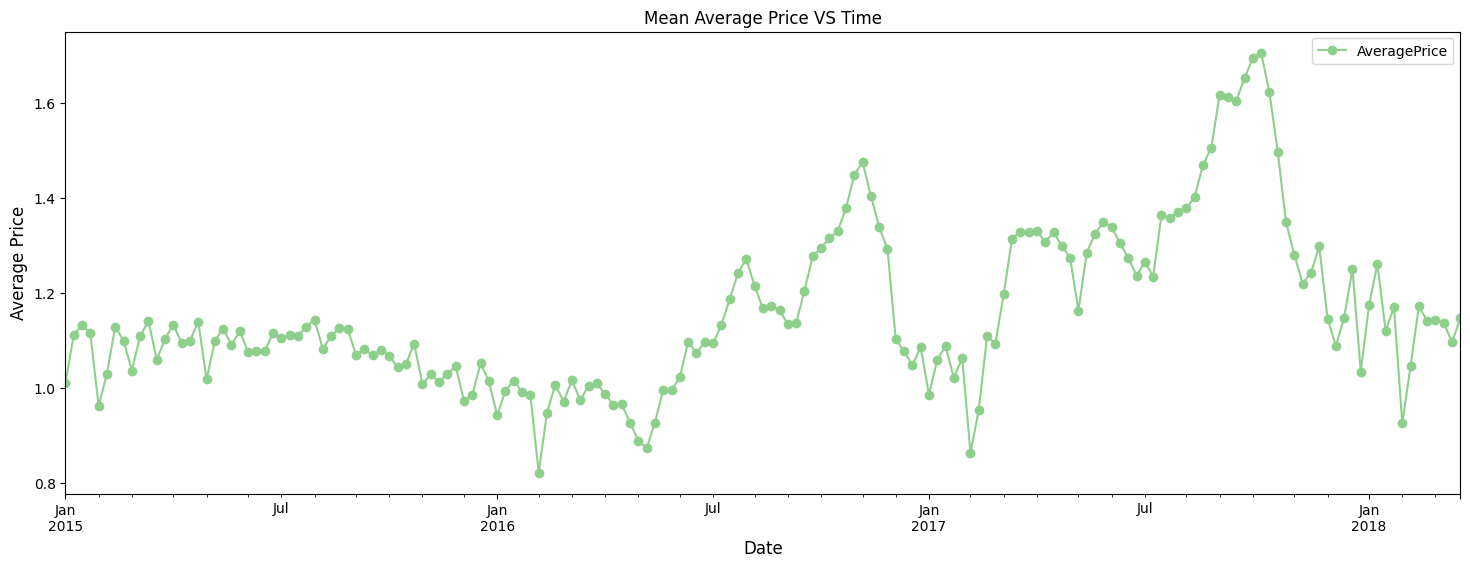

In [27]:
# promedio de 'AveragePrice' para cada fecha
fig, ax = plt.subplots(1,1, figsize=(18,6))
avocado_conv.groupby('Date')['AveragePrice'].mean().reset_index().set_index('Date').plot(ax=ax, marker = 'o', linestyle = '-', color = green_palette[2])
plt.title('Mean Average Price (Conventional) VS Time', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price', fontsize=12);

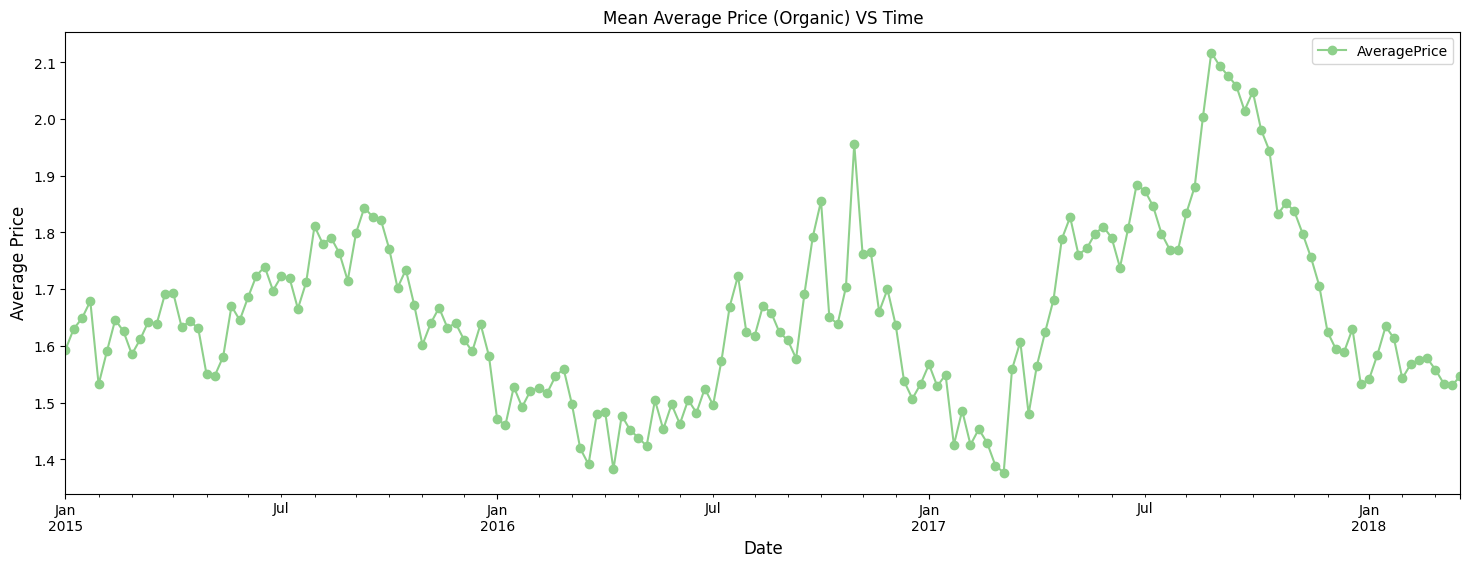

In [28]:
# promedio de 'AveragePrice' para cada fecha
fig, ax = plt.subplots(1,1, figsize=(18,6))
avocado_org.groupby('Date')['AveragePrice'].mean().reset_index().set_index('Date').plot(ax=ax, marker = 'o', linestyle = '-', color = green_palette[2])
plt.title('Mean Average Price (Organic) VS Time', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price', fontsize=12);

OBSERVACIONES

- Los precios son mayores de julio a septiembre-octubre.
- En 2018 los precios fueron mayores que en los años anteriores.

---
### Aplicamos **ARIMA**

Tenemos que establecer los valores p, d, q:

- Parámetro p - AUTORREGRESIVO (**AR**): es el orden del componente autorregresivo del modelo. Representa el número de rezagos (lags) de la serie temporal que se usan en el modelo.
- Parámetro d - DIFERENCIACIÓN (**I**): es el número de veces que se debe diferenciar la serie temporal para que se vuelva estacionaria. 
- Parámetro q - MEDIA MÓVIL (**MA**): Representa el número de rezagos (lags) de los errores de predicción que se usan en el modelo.

**PASOS A SEGUIR**:
#### ¿Tiene tendencia o es estacionaria? --> Parametro ``d``

In [19]:
# Aplicamos adfuller para establecer el parámetro
print(f"p-valor diferenciación orden cero: {adfuller(avocado['AveragePrice'])[1]}") # devuelve un estadistico y un pvalor, y queremos el pvalor[1]
print(f"p-valor diferenciación orden uno: {adfuller(avocado['AveragePrice'].diff().dropna())[1]}")
print(f"p-valor diferenciación orden dos: {adfuller(avocado['AveragePrice'].diff().diff().dropna())[1]}")

p-valor diferenciación orden cero: 5.7160690959319934e-11
p-valor diferenciación orden uno: 0.0
p-valor diferenciación orden dos: 0.0


Todos son menores de 0.05, por lo que la consideramos la serie **estacionaria**.

De aquellos pvalor que pasan el 0.05, me quedo con el que tenga menos diferenciación: La diferenciación de orden 0 (sin diferenciar).

Por lo tanto, ``d=0``.

#### Parametros ``p`` y ``q`` --> **auto_arima**

Aplicamos auto_arima para que nos de el mejor modelo:

In [27]:
# aplicamos auto_arima
model = auto_arima(avocado['AveragePrice'], start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=0,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-13579.018, Time=1.70 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65665.108, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=44110.765, Time=1.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-13719.457, Time=4.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.95 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-13717.500, Time=10.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-13709.139, Time=4.63 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-13712.561, Time=4.50 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=3.00 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-13727.636, Time=10.40 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-13732.748, Time=12.90 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-13713.765, Time=7.39 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=26.44 sec
 ARIMA(4,0,3)(0,0,0)[0]        

Vamos a tomar finalmente modelo $\text{ARIMA}(p=3,\,d=0,\,q=3)$. Ya tenemos los parámetros, ahora vamos a ajustar el modelo:

#### Modelizacion

In [20]:
# Ajustamos modelo a datos
model = ARIMA(avocado['AveragePrice'].values, order=(3,0,3))
model_fit = model.fit()
# Resumen del entrenamiento
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18249
Model:                 ARIMA(3, 0, 3)   Log Likelihood                7022.721
Date:                Wed, 21 Aug 2024   AIC                         -14029.442
Time:                        09:45:55   BIC                         -13966.947
Sample:                             0   HQIC                        -14008.904
                              - 18249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4062      0.023     62.032      0.000       1.362       1.451
ar.L1         -0.0495      0.052     -0.944      0.345      -0.152       0.053
ar.L2          0.5740      0.048     11.886      0.0

#### Visualizacion del modelo entrenado

`plot_diagnostics` nos muestra (de izquierda a derecha y de arriba hacia abajo) la gráfica real del ruido, el histograma real y estimado, el gráfico de cuantiles y un correlograma:

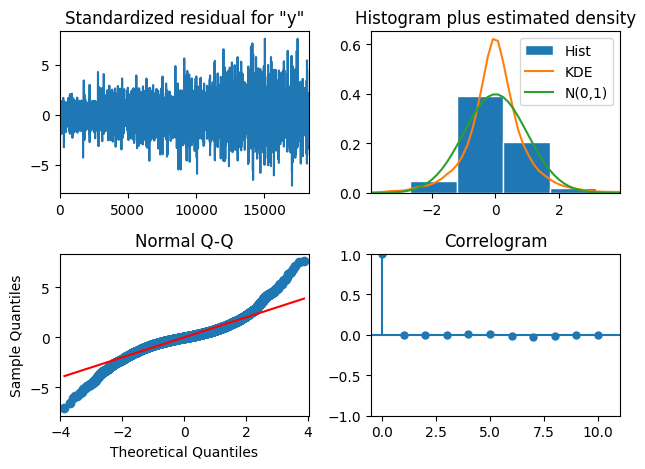

In [80]:
model_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

El residuo ha variado mucho, pero con Arima es lo mejor que podemos sacar.

#### Visualizacion de las predicciones

Para comprobar la calidad del ajuste del modelo entrenado a los datos de la serie temporal proporcionados, podemos usar el método `predict` del modelo ARIMA entrenado para trazar los valores reales y pronosticados uno encima del otro. Este gráfico lineal se calcula a partir de los pesos aprendidos y entrenados por el modelo. Verifiquemos qué tan bien funciona la predicción en función de los coeficientes aprendidos:

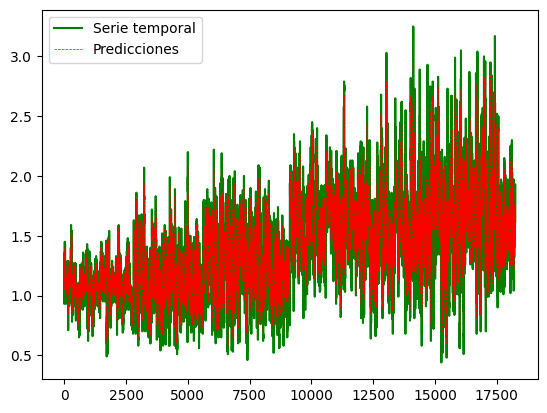

In [82]:
p = 3 # Coeficientes de autoregresión
d = 0 # Orden de diferenciación
q = 3 # Ajuste media móvil
# Tomamos predicciones
preds = model_fit.predict()
# Creamos figura
fig, ax = plt.subplots()
ax.plot(range(len(avocado)), avocado['AveragePrice'].values, 'g-')
ax.plot(range(d,len(avocado)), preds[d:], 'r--',linewidth=0.5)
plt.legend(['Serie temporal', 'Predicciones'])
plt.show()

#### Predicciones

In [14]:
# Hacemos predicciones
model_fit.forecast() # Al día siguiente, va a haber ese precio medio
model_fit.forecast(2) # En los siguientes 2 días

array([1.67494552, 1.68561834])

### Aplicamos **Prophet**

Prophet es una biblioteca de software para modelar y realizar previsiones en series temporales, desarrollada por Facebook. Prophet funciona mejor con series temporales que tienen efectos estacionales fuertes y varios años de datos históricos.

In [61]:
avocado.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


#### Filtramos dataframe

Vamos a quedarnos solo con las columnas ``Date`` y ``AveragePrice``:

In [62]:
col = ['Date', 'AveragePrice']
avocado_prophet = avocado[col].copy()

#### Renombramos columnas y cambiamos formato de fechas

In [63]:
# Renombramos columnas (deben llamarse exactamente así)
avocado_prophet.rename(columns = {'Date':'ds', 'AveragePrice':'y'}, inplace = True)
# Cambiamos formato a fechas
avocado_prophet['ds'] = pd.DatetimeIndex(avocado_prophet['ds'])
# Mostramos
avocado_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      18249 non-null  datetime64[ns]
 1   y       18249 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 285.3 KB


In [64]:
avocado_prophet.head()

,ds,y
0,2015-12-27,1.33
1,2015-12-20,1.35
2,2015-12-13,0.93
3,2015-12-06,1.08
4,2015-11-29,1.28


#### Entrenamos modelo Prophet

In [66]:
# Instanciamos clase
m = Prophet()
# Entrenamos modelo
m.fit(avocado_prophet)

13:08:41 - cmdstanpy - INFO - Chain [1] start processing
13:08:48 - cmdstanpy - INFO - Chain [1] done processing


#### Realizamos predicciones

In [67]:
future =  m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

In [68]:
future.tail()

,ds
529,2019-03-21
530,2019-03-22
531,2019-03-23
532,2019-03-24
533,2019-03-25


In [69]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
529,2019-03-21,1.080679,0.546782,1.576560
530,2019-03-22,1.081751,0.571135,1.593971
531,2019-03-23,1.083100,0.566270,1.583022
532,2019-03-24,1.084708,0.509126,1.602538
533,2019-03-25,1.086547,0.556343,1.596683


#### Visualizamos las predicciones

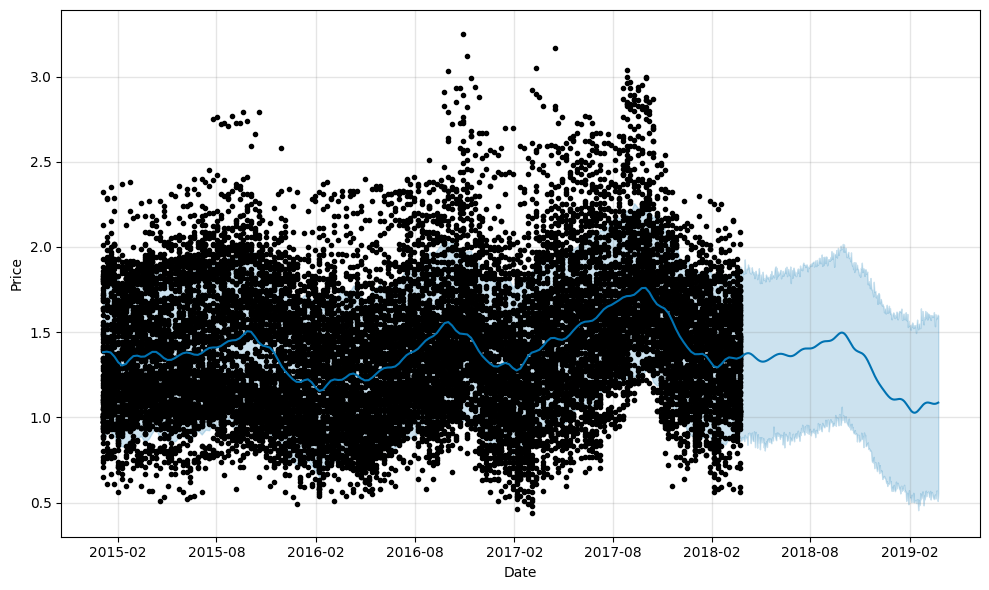

In [73]:
# prediccion para 1 año
fig1 = m.plot(forecast, xlabel ='Date', ylabel = 'Price')

COMPONENTES DEL GRÁFICO:

- **Línea azul oscura**: Representa la tendencia esperada para el precio en la serie temporal, realizada por el modelo Prophet.
- **Sombra azul**: Representa el intervalo de confianza (por defecto es el 80%) alrededor de la predicción central, es decir, refleja la incertidumbre en la predicción.
- **Puntos negros**: Representan los datos históricos observados.

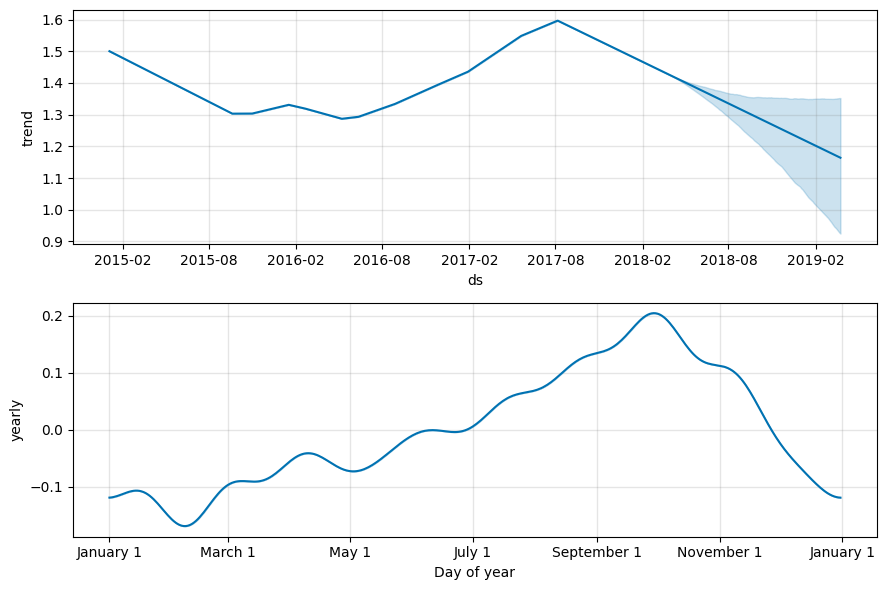

In [77]:
fig2 = m.plot_components(forecast)

COMPONENTES DEL GRÁFICO: 

1. El primer gráfico muestra la tendencia a largo plazo (*trend*) del precio en la serie temporal. Indica si la variable predicha (precio) está aumentando, disminuyendo o manteniéndose estable a lo largo del tiempo. **En este caso, parece que la tendencia disminuye en la predicción para un año**.

2. El segundo gráfico muestra la variación del precio a lo largo de un año (*yearly*). Este componente te permite ver cómo los valores predichos fluctúan dentro de un año, reflejando estacionalidades anuales. **En este caso, podemos ver que el precio de los aguacates alcanza un pico en el mes de octubre**.

#### Prediccion para una region concreta: Las Vegas

In [82]:
avocado['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [81]:
avocado_lasvegas = avocado[avocado['region']=='LasVegas']

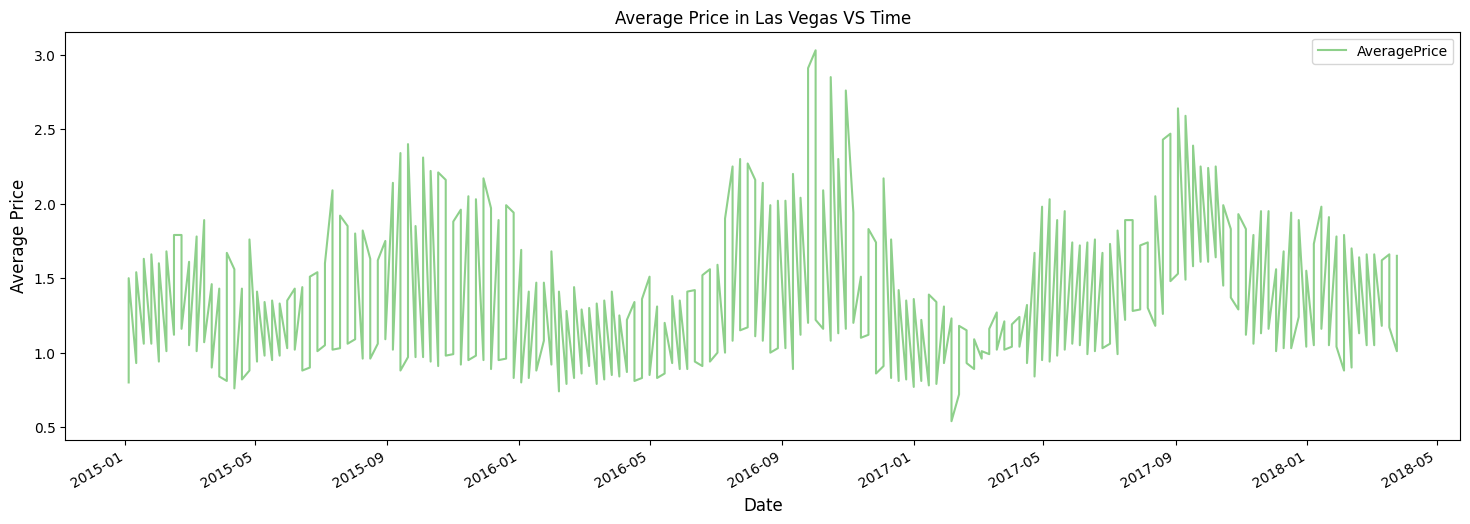

In [83]:
# graficamos la serie temporal del precio de los aguacates en las vegas
fig, ax = plt.subplots(1,1, figsize=(18,6))
avocado_lasvegas.set_index('Date').plot(y='AveragePrice', ax=ax, color=green_palette[2])
plt.title('Average Price in Las Vegas VS Time', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price', fontsize=12);

In [85]:
# filtramos el dataframe y nos quedamos con las columnas Date y AveragePrice
avocado_lasvegas_prophet = avocado_lasvegas[col].copy()

In [86]:
# Renombramos columnas y cambiamos formato de fechas
avocado_lasvegas_prophet.rename(columns = {'Date':'ds', 'AveragePrice':'y'}, inplace = True)
avocado_lasvegas_prophet['ds'] = pd.DatetimeIndex(avocado_lasvegas_prophet['ds'])
# Mostramos
avocado_lasvegas_prophet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 1092 to 17864
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      338 non-null    datetime64[ns]
 1   y       338 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.9 KB


In [88]:
# entrenamos modelo y realizamos predicciones

# Instanciamos clase
m = Prophet()
# Entrenamos modelo
m.fit(avocado_lasvegas_prophet)
# realizamos predicciones
future =  m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

09:15:02 - cmdstanpy - INFO - Chain [1] start processing
09:15:02 - cmdstanpy - INFO - Chain [1] done processing


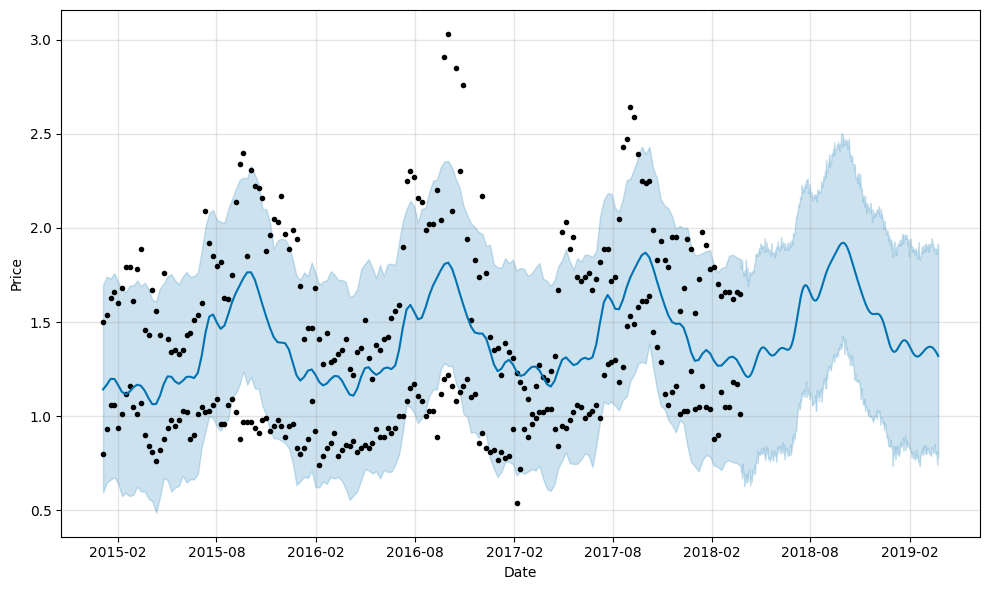

In [89]:
# graficamos predicciones
fig1 = m.plot(forecast, xlabel ='Date', ylabel = 'Price')

En este caso, parece que el precio del aguacate aumentará a partir de febrero de 2018, al contrario de lo que ocurre en la previsión a nivel de país.

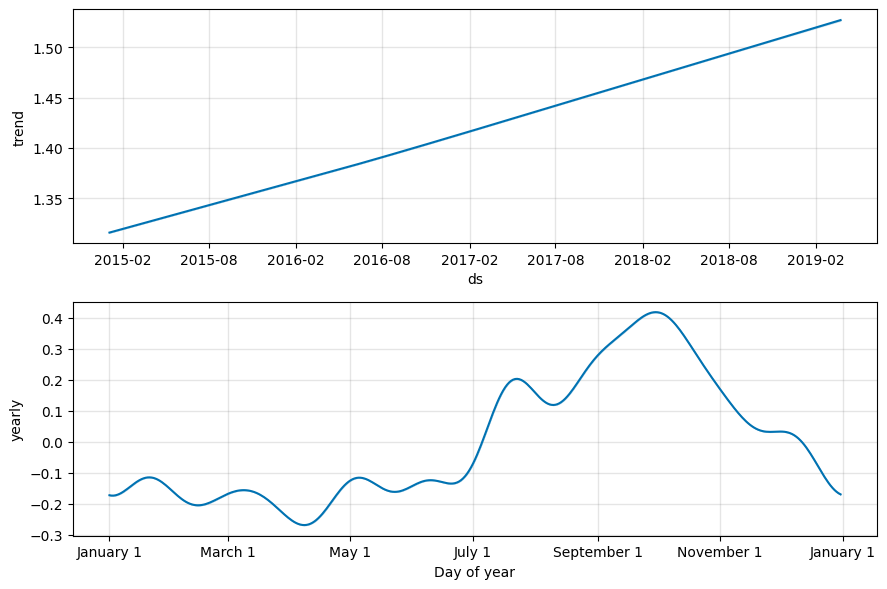

In [90]:
# graficamos componentes de la prediccion
fig2 = m.plot_components(forecast)

La tendencia, como podemos observar, se incrementa a lo largo del tiempo.

La estacionalidad es similar a la y a nivel de país, ya que alcanza un pico en el mes de octubre.